In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from shapely import geometry, ops
import pyproj
import rasterio
import rasterio.merge
from rasterio.merge import merge
from pysheds.grid import Grid


warnings.filterwarnings('ignore')

%matplotlib inline 
# To display plots inline in the notebook

In [3]:
grid_top = Grid.from_raster('D:\input\Taskin_Hesap_Staj\ASTGTM_N37E035_dem.tif')
dem_top = grid_top.read_raster('D:\input\Taskin_Hesap_Staj\ASTGTM_N37E035_dem.tif')

grid_bottom = Grid.from_raster('D:\input\Taskin_Hesap_Staj\ASTGTM_N36E035_dem.tif')
dem_bottom = grid_bottom.read_raster('D:\input\Taskin_Hesap_Staj\ASTGTM_N36E035_dem.tif')

In [4]:
# Specify file paths
file_path_top = 'D:\input\Taskin_Hesap_Staj\ASTGTM_N37E035_dem.tif'
file_path_bottom = 'D:\input\Taskin_Hesap_Staj\ASTGTM_N36E035_dem.tif'

# Open raster files using the rasterio library
dataset_top = rasterio.open(file_path_top)
dataset_bottom = rasterio.open(file_path_bottom)

# Merge two raster datasets
datasets_to_merge = [dataset_top, dataset_bottom]   # Place the files to be merged into a list
merged, out_transform = merge(datasets_to_merge)    # Perform the merging operation

# Set metadata for the output file
out_meta = dataset_top.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": merged.shape[1],
                 "width": merged.shape[2],
                 "transform": out_transform})

# Write the merged data to an output file
output_path = 'D:\input\Taskin_Hesap_Staj\merged_output.tif'
with rasterio.open(output_path, "w", **out_meta) as dest:
    dest.write(merged)

out_transform değişkeni, birleştirilmiş raster verisinin piksel koordinatlarını dünya koordinatlarına dönüştürmek için kullanılan dönüşüm matrisini içerir. Bu matris, bir pikselin konumuyla ilgili geometrik dönüşümleri temsil eder. Örneğin, bir pikselin satır ve sütun indeksleri ile dünya koordinatları arasındaki ilişkiyi sağlamak için kullanılır.

In [5]:
grid = Grid.from_raster('D:\input\Taskin_Hesap_Staj\merged_output.tif')
dem = grid_top.read_raster('D:\input\Taskin_Hesap_Staj\merged_output.tif')

In [6]:
#Here, grid is the Grid instance, and dem is a Raster object. 
#If we call the Raster object, we will see that it looks much like a numpy array.

merged

array([[[1745, 1747, 1747, ..., 1312, 1316, 1320],
        [1747, 1749, 1749, ..., 1317, 1320, 1322],
        [1749, 1750, 1751, ..., 1325, 1327, 1328],
        ...,
        [   0,    0,    0, ...,  587,  583,  579],
        [   0,    0,    0, ...,  590,  587,  583],
        [   0,    0,    0, ...,  592,  590,  588]]], dtype=int16)

In [7]:
#Hydrologic functions (such as flow direction determination and catchment delineation) 
#accept and return Raster objects:
inflated_dem = grid.resolve_flats(dem)
fdir = grid.flowdir(inflated_dem)
fdir

Raster([[  0,   0,   0, ...,   0,   0,   0],
        [  0,  32,  64, ...,  32,  32,   0],
        [  0,  32,  64, ...,  64,  32,   0],
        ...,
        [  0,  16,   4, ..., 128, 128,   0],
        [  0,   4,   4, ..., 128, 128,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=int64)

grid.resolve_flats(dem):
Bu fonksiyon, düzlükleri çözmek için kullanılır. Düz bir yüzeye sahip olan bölgeler, suyun akışını ve topografik eğimleri hesaplamak açısından problem oluşturabilir. resolve_flats fonksiyonu, bu düzlükleri çözerek daha gerçekçi akış yönü hesaplamaları sağlar. İçine DEM (Digital Elevation Model) verisini alır ve düzlükleri çözülmüş bir DEM döndürür.

grid.flowdir(inflated_dem):
Bu fonksiyon, akış yönlerini hesaplamak için kullanılır. Düzeltme yapılmış DEM verisini alır ve her pikselin suyun akış yönünü belirler. Bu akış yönleri, yüksekliklerin eğim yönlerine göre belirlendiği bir topografik modeli temsil eder. D8 akış yöntemi kullanılarak akış yönleri hesaplanır. Akış yönleri, pikselin bit maske olarak temsil edildiği bir dizi olarak döndürülür.

Bu fonksiyonların bir arada kullanımı, topografik verilerden akış yönlerini ve düzlükleri çözmüş bir model oluşturmanıza yardımcı olur. Bu tür modeller, suyun nasıl akacağını, hangi bölgelerin daha düşük veya daha yüksek eğime sahip olduğunu anlamak için sıkça kullanılır.

In [8]:
#The viewfinder attribute contains all the information needed 
#to specify the Raster’s spatial reference system. 
#It can be accessed using the viewfinder attribute.
dem.viewfinder

'affine' : Affine(0.0002777777777777778, 0.0, 34.99986111111111,
       0.0, -0.0002777777777777778, 38.00013888888889)
'shape' : (7201, 3601)
'nodata' : 0
'crs' : <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

'mask' : array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

dem.viewfinder çıktısı bir DEM (Digital Elevation Model) verisini temsil eden bir nesnenin özelliklerini ve değerlerini içerir.

'affine': Bir affine dönüşüm matrisini temsil eder. Bu matris, her pikselin koordinatlarını dünya koordinatlarına dönüştürmek için kullanılır. Örneğin, matrisin [0,0] öğesi piksel boyutunu (genellikle metre cinsinden) ve [2,2] öğesi yükseklik değerini temsil eder.

'shape': DEM verisinin boyutunu (satır, sütun) belirtir. Bu örnekte (7201, 3601) boyutlu bir DEM olduğunu gösterir.

'nodata': Tif verisinde belirtilen "no data" veya "masked" değeri. Yani, veri olmayan veya maske değeri olarak kullanılan piksellerin değerini temsil eder. Bu örnekte 0 olarak belirtilmiş.

'crs': Koordinat referans sistemi (Coordinate Reference System - CRS) bilgisini içerir. Bu, verinin hangi coğrafi veya projeksiyonel sistemde tanımlandığını belirtir. Örneğin, EPSG:4326 WGS 84 coğrafi referans sistemi anlamına gelir.

'mask': Maskeleme verisi veya "no data" değerlerinin olduğu yerleri belirleyen bir boolean NumPy dizisini temsil eder. True değerler verinin var olduğu alanı, False değerler ise verinin olmadığı veya maske değerinin olduğu alanı gösterir.

In [9]:
dem.affine # Affine transformation

Affine(0.0002777777777777778, 0.0, 34.99986111111111,
       0.0, -0.0002777777777777778, 38.00013888888889)

Bu çıktı, bir DEM verisinin affine dönüşüm matrisini temsil eder. Affine dönüşüm matrisi, bir pikselin (satır ve sütun koordinatları) dünya koordinatlarına dönüştürülmesi için kullanılır.

(0.0002777777777777778, 0.0): İlk öğe, x-yönünde piksel boyutunu temsil eder. Yani, bir pikselin genişliğidir.

(0.0, -0.0002777777777777778): İkinci öğe, y-yönünde piksel boyutunu temsil eder. Yani, bir pikselin yüksekliğidir.

(34.99986111111111, 38.00013888888889): Bu öğeler, dönüşümün başlangıç noktasını temsil eder. İlk öğe, x-yönünde başlangıç noktasını belirtir, ikinci öğe ise y-yönünde başlangıç noktasını belirtir.

Bu matris, piksel koordinatlarını dünya koordinatlarına ve tersi olarak dönüştürmek için kullanılır. Yani, bir pikselin koordinatlarını alırken veya dünya koordinatlarını piksel koordinatlarına dönüştürürken kullanılır. Bu, coğrafi verileri işlemek veya görselleştirmek için önemli bir konsepttir.

In [10]:
dem.shape # Shape of the raster

(7201, 3601)

dem.shape ifadesi, bir DEM (Digital Elevation Model) verisinin boyutunu temsil eder. Boyut, veri dizisinin satır ve sütun sayısını belirtir. 

Bu çıktıda, DEM verisinin 7201 satır ve 3601 sütundan oluştuğunu görüyoruz. Bu, veri matrisinin 7201 satır ve 3601 sütundan oluşan bir yapıya sahip olduğu anlamına gelir. Bu matris, yatayda 3601 piksel ve dikeyde 7201 piksel içerir. Her bir piksel bir yükseklik değeri içerir ve bu değerlerin dünya koordinatlarına dönüştürülmesi affine dönüşüm matrisi ile yapılır.

In [11]:
dem.crs # Coordinate reference system

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

dem.crs ifadesi, bir DEM (Digital Elevation Model) verisinin coğrafi referans sistemi (Coordinate Reference System - CRS) bilgisini temsil eder. Coğrafi referans sistemi, verinin hangi coğrafi veya projeksiyonel sisteme göre tanımlandığını belirtir.

Bu çıktı, verinin WGS 84 coğrafi referans sistemi (EPSG:4326) kullanılarak tanımlandığını gösterir. Bu referans sistemi dünya genelinde en yaygın olarak kullanılan coğrafi referans sistemlerinden biridir. Ayrıca, çıktıda elipsoid (Yerelips) ve Prime Meridian (Başmeridyen) gibi diğer bilgiler de belirtilir.

In [12]:
dem.mask # Mask of the raster

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

dem.mask ifadesi, bir DEM (Digital Elevation Model) verisinin maskesini temsil eder. Bir maske, veri setinin belirli piksel değerlerini gizlemek veya seçmek için kullanılan bir boolean (True/False) dizisidir.

Bu çıktı, DEM verisinin tamamının maskesinin True olarak ayarlandığını gösterir. Yani, veri setindeki her pikselin değeri görünür ve kullanılabilir durumdadır. Eğer maske değerleri olsaydı, False değerleri belirli piksellerin gizlendiğini veya işleme alınmadığını gösterirdi.

In [13]:
dem.nodata # No data value

0

dem.nodata ifadesi, bir DEM (Digital Elevation Model) verisinin "no data" veya "masked" değerini temsil eder. Bu değer, veri setindeki bazı piksellerin geçersiz veya eksik veri olduğunu gösterir. Yani, bu değere sahip pikseller gerçek dünya yüzeyini temsil etmez.

Bu çıktı, DEM verinizde "no data" veya "masked" değeri olarak 0 kullanıldığını gösterir. Bu durumda, 0 değeri gerçek dünya yüzeyinin temsil edilmemesi anlamına gelir. Eğer veri setinde başka bir "no data" değeri belirlenmişse, o değeri burada görülecektir.

In [14]:
dem.bbox # Bounding box

(34.99986111111111, 35.999861111111116, 36.000138888888884, 38.00013888888889)

dem.bbox ifadesi, bir DEM (Digital Elevation Model) verisinin sınırlarını temsil eden bir dikdörtgenin koordinatlarını verir. Bu koordinatlar, veri setinin dört köşesini belirler ve verinin sınırlarını gösterir.

Bu çıktı, DEM verisinin sınırlarını belirleyen dört koordinatı temsil eder. Sırasıyla, bu koordinatlar:

Batı sınırının enlem değeri: 34.99986111111111

Doğu sınırının enlem değeri: 35.999861111111116

Güney sınırının boylam değeri: 36.000138888888884

Kuzey sınırının boylam değeri: 38.00013888888889

In [15]:
dem.extent # Extent

(34.99986111111111, 36.000138888888884, 35.999861111111116, 38.00013888888889)

dem.extent ifadesi, bir DEM (Digital Elevation Model) verisinin sınırlarını temsil eden bir dikdörtgenin koordinatlarını verir. Bu koordinatlar, veri setinin batı, doğu, güney ve kuzey sınırlarını belirler ve verinin sınırlarını gösterir.
Bu çıktı, DEM verisinin sınırlarını belirleyen dört koordinatı temsil eder. Sırasıyla, bu koordinatlar:

Batı sınırının boylam değeri: 34.99986111111111

Doğu sınırının boylam değeri: 36.000138888888884

Güney sınırının enlem değeri: 35.999861111111116

Kuzey sınırının enlem değeri: 38.00013888888889

In [16]:
dem.coords # Coordinates

array([[38.00013889, 34.99986111],
       [38.00013889, 35.00013889],
       [38.00013889, 35.00041667],
       ...,
       [36.00013889, 35.99930556],
       [36.00013889, 35.99958333],
       [36.00013889, 35.99986111]])

dem.coords ifadesi, bir DEM (Digital Elevation Model) verisinin piksellerin dünya koordinatlarını içeren bir dizi olarak temsil eder. Bu dizi, her pikselin koordinatlarını içerir ve verinin tüm piksel koordinatlarını gösterir.

Bu çıktı, DEM verisinin tüm piksellerinin dünya koordinatlarını içeren bir dizi olarak temsil eder. Her satır bir pikselin koordinatlarını belirtir. İlk sütun y-koordinatı (enlem), ikinci sütun x-koordinatı (boylam) olarak temsil edilir.

In [17]:
#Rasters can be instantiated directly using the pysheds.Raster class. 
#Both an array-like object and a ViewFinder must be provided.
from pysheds.view import Raster, ViewFinder

array = np.random.randn(*grid.shape) # Create a random array
raster = Raster(array, viewfinder=grid.viewfinder) # Instantiate a Raster object

Bu kod parçasında PySheds kütüphanesinin Raster sınıfı kullanılarak bir rastgele sayılardan oluşan bir rastgele sayı dizisi (array) oluşturuluyor. Bu rastgele sayı dizisi, Raster sınıfına array argümanı olarak verilirken, aynı zamanda viewfinder olarak da bir Grid nesnesi (grid.viewfinder) ile birlikte kullanılıyor.

Bu çıktı, oluşturulan rastgele sayı dizisinin içeriğini temsil eder. Bu dizi, örneğin bir topografik yükseklik değeri dizisi olabilir. Raster sınıfı, bu tür rastgele veya gerçek veri dizilerini işlemek ve analiz etmek için kullanışlı bir yapı sağlar. viewfinder argümanı, dizinin coğrafi koordinatlarına nasıl eşleştiğini belirlemek için kullanılır.

In [18]:
raster

Raster([[ 0.20166947,  1.47583056,  0.36812916, ..., -0.65924762,
         -0.36418729, -0.70877722],
        [ 0.63021748,  0.72402954,  1.91314061, ...,  0.53573947,
          0.27058383, -0.58118863],
        [ 0.75344294, -0.80339251, -0.18346761, ..., -0.1767556 ,
         -0.51233211, -0.71698254],
        ...,
        [-0.31269725,  1.24212155,  0.77174346, ...,  1.01114007,
          1.52183705,  1.80967655],
        [-0.98297676, -0.5869105 , -0.97542669, ..., -0.11276676,
         -0.82082332,  0.35039517],
        [-0.26427342,  0.9725271 ,  0.72453957, ..., -0.20945277,
          1.20355549, -0.6311218 ]])

In [19]:
# shape=array.shape defined in the Raster object
raster = Raster(array, viewfinder=ViewFinder(shape=array.shape)) # Instantiate a Raster object

ViewFinder nesnesi, bir grid (izdüşüm) üzerinde belirli bir şekli temsil eder. Bu durumda, shape özelliği, array'in şekline eşittir. Yani, ViewFinder(shape=array.shape) ifadesi, array'in şekline uygun bir ViewFinder nesnesi oluşturur.

In [20]:
raster.viewfinder

'affine' : Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)
'shape' : (7201, 3601)
'nodata' : 0
'crs' : <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

'mask' : array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

# Farklı Bir Coordinate Reference System Oluşturma

In [21]:
# Initialize new CRS
new_crs = pyproj.Proj('epsg:3083') # EPSG code for GDA94 / Australian Albers

# Convert CRS of dataset and set nodata value for better plotting
dem.nodata = np.nan
proj_dem = dem.to_crs(new_crs) 

Yeni bir koordinat referans sistemi (CRS) oluşturma: new_crs = pyproj.Proj('epsg:3083') ifadesi, 'EPSG:3083' koduna sahip bir CRS oluşturuyor. Bu kod, belirli bir projeksiyon sistemini ifade eder. Burada, projeksiyon dönüşümlerini bu yeni CRS üzerinden yapmak istediğinizi belirtiyoruz.

Nodata değerini ayarlama: dem.nodata = np.nan ifadesi, dem (Digital Elevation Model) verisi içindeki geçersiz (no data) değerleri np.nan (NaN olarak bilinen sayısal olmayan bir değer) ile değiştiriyor. Bu işlem, daha sonra yapacağınız görselleştirmeler sırasında geçersiz değerleri daha iyi işlemek ve görselleştirmek için kullanışlıdır.

CRS dönüşümü: proj_dem = dem.to_crs(new_crs) ifadesi, dem verisini yeni oluşturduğunuz CRS (new_crs)'e dönüştürüyor. Bu, verinin koordinatlarını yeni projeksiyon sistemine dönüştürmek anlamına gelir.

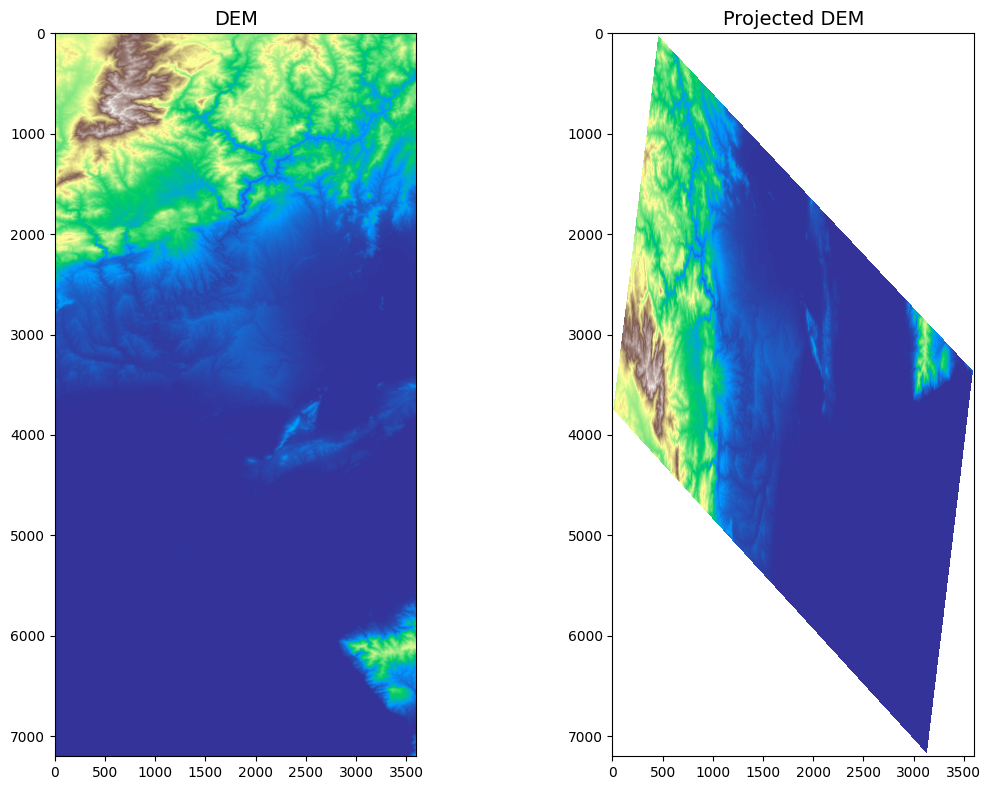

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,8))
fig.patch.set_alpha(0)
ax[0].imshow(dem, cmap='terrain', zorder=1)
ax[1].imshow(proj_dem, cmap='terrain', zorder=1)
ax[0].set_title('DEM', size=14)
ax[1].set_title('Projected DEM', size=14)
plt.tight_layout()

# DEM Conditioning

In [23]:
# Detecting pits
merged_output_path = 'D:\input\Taskin_Hesap_Staj\merged_output.tif'

grid = Grid.from_raster(merged_output_path)
dem = grid.read_raster(merged_output_path)

pits = grid.detect_pits(dem) # Detect pits

grid.detect_pits(dem) ile tespit edilen çukurların (depresyonlar) bir boolean dizisi olan pits olarak elde edilir. Bu dizinin her bir elemanı, ilgili hücrenin bir çukurun içinde olup olmadığını belirtir. True değeri bir çukur içinde olduğunu, False değeri ise bir çukur içinde olmadığını gösterir.

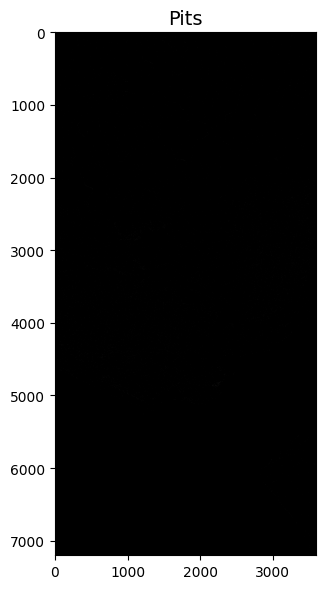

In [24]:
# Plotting pits
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(pits, cmap='Greys_r', zorder=1)
plt.title('Pits', size=14)
plt.tight_layout()

Bu kodun sonucunda, pits adlı boolean dizisinin True ve False değerlerine göre oluşturulmuş siyah-beyaz bir görüntü elde edilir. Bu görüntüde, beyaz pikseller çukurları (depresyonları) ve siyah pikseller diğer alanları temsil eder. 

In [25]:
print(pits)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [26]:
# Filling Pits

pit_filled_dem = grid.fill_pits(dem) # Fill pits
pits = grid.detect_pits(pit_filled_dem)
assert pits.any()

pit_filled_dem = grid.fill_pits(dem) ile grid nesnesinin fill_pits metodu çağrılarak çukurlar doldurulur. Bu işlem sonucunda, çukurların doldurulmuş hali olan pit_filled_dem adlı bir DEM (Dijital Yükseklik Modeli) oluşturulur.

pits = grid.detect_pits(pit_filled_dem) ile grid nesnesinin detect_pits metodu çağrılarak doldurulmuş DEM üzerinde yeni çukurların tespit edilmesi sağlanır. pits adlı boolean dizisi, yeni tespit edilen çukurların konumunu belirtir.

In [27]:
# Detect depressions
depressions = grid.detect_depressions(pit_filled_dem)

depressions = grid.detect_depressions(pit_filled_dem) ile grid nesnesinin detect_depressions metodu çağrılarak doldurulmuş DEM üzerinde depresyonların tespiti yapılır. depressions adlı boolean dizisi, depresyonların konumunu belirtir. True değeri, bir hücrenin depresyon içinde olduğunu gösterir.

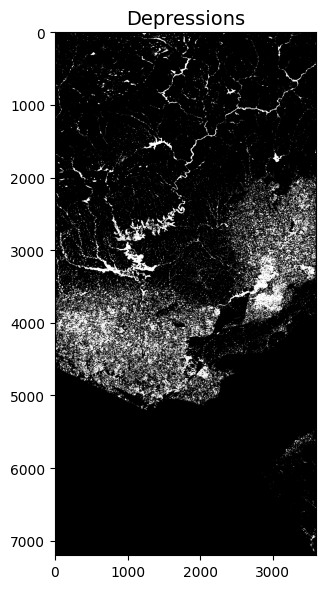

In [28]:
# Plot depressions
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(depressions, cmap='Greys_r', zorder=1)
plt.title('Depressions', size=14)
plt.tight_layout()

depressions, drenaj sistemi içindeki çukurları (depresyonları) tespit etmek için kullanılan bir boolean (True/False) dizisidir. Bu dizinin her bir elemanı, verinin içindeki ilgili hücrenin bir çukurun içinde olup olmadığını belirtir.

Yani, depressions dizisinin her bir hücresi, ilgili hücrenin bir depresyon içinde bulunup bulunmadığını gösterir. Eğer bir hücre bir çukurun içindeyse, o hücrenin değeri True olur. Eğer bir hücre çukur içinde değilse, değeri False olur.

In [29]:
flooded_dem = grid.fill_depressions(pit_filled_dem) # Fill depressions
depressions = grid.detect_depressions(flooded_dem) # Detect depressions
assert depressions.any() # Check that there are no depressions remaining

flooded_dem = grid.fill_depressions(pit_filled_dem) ile grid nesnesinin fill_depressions metodu çağrılarak, doldurulmuş DEM üzerindeki depresyonlar doldurulur. Bu işlem sonucunda, depresyonların doldurulmuş hali olan flooded_dem adlı bir DEM elde edilir.

depressions = grid.detect_depressions(flooded_dem) ile doldurulmuş depresyonların doldurulmuş DEM üzerinde yeniden tespiti yapılır. depressions adlı boolean dizisi, doldurulmuş DEM üzerindeki depresyonların konumunu belirtir.

In [30]:
# Detect flats
flats = grid.detect_flats(flooded_dem)

Düzlüklerin (flats) tespiti işlemi için kullanılır. Düzlükler, yüzeyde eğim olmadığı veya çok az eğim olduğu alanlardır. Bu tür alanlarda suyun birikme eğilimi olabilir.

flats = grid.detect_flats(flooded_dem) ile grid nesnesinin detect_flats metodu çağrılarak, doldurulmuş depresyonların tespit edildiği DEM üzerinde düzlüklerin tespiti yapılır. flats adlı boolean dizisi, düzlüklerin konumunu belirtir. True değeri, bir hücrenin düzlükte olduğunu gösterir.

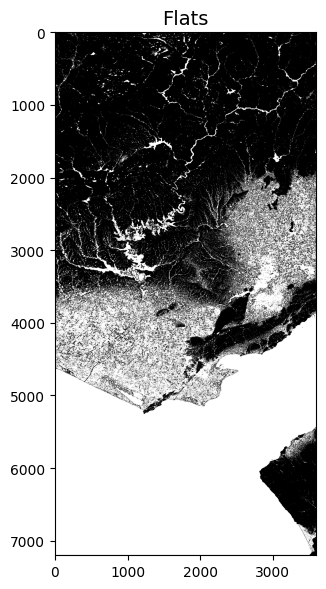

In [31]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(flats, cmap='Greys_r', zorder=1)
plt.title('Flats', size=14)
plt.tight_layout()

In [32]:
inflated_dem = grid.resolve_flats(flooded_dem) # Resolve flats
flats = grid.detect_flats(inflated_dem) # Detect flats
assert flats.any() # Check that there are no flats remaining

inflated_dem = grid.resolve_flats(flooded_dem) ile grid nesnesinin resolve_flats metodu çağrılarak, doldurulmuş depresyonlar ve tespit edilen düzlüklerin çözümü yapılır. Çözüme göre, düzlüklerin yüzey eğimleri artırılır, böylece suyun düzgün bir şekilde akması sağlanır. Bu işlem sonucunda, çözülmüş düzlüklerin olduğu inflated_dem adlı bir DEM elde edilir.

flats = grid.detect_flats(inflated_dem) ile çözülmüş düzlüklerin tespiti yapılır. flats adlı boolean dizisi, çözülmüş düzlüklerin konumunu belirtir. True değeri, bir hücrenin çözülmüş düzlükte olduğunu gösterir.

In [33]:
# Compute flow direction based on corrected DEM
fdir = grid.flowdir(inflated_dem)

# Compute flow accumulation based on computed flow direction
acc = grid.accumulation(fdir)

fdir = grid.flowdir(inflated_dem) ile grid nesnesinin flowdir metodu çağrılarak, düzeltilmiş DEM (inflated_dem) temelinde akış yönleri hesaplanır. Bu işlem, her bir hücrenin komşu hücrelerine göre akış yönünü belirler. Sonuç olarak, her hücre için bir akış yönü kodu (flow direction code) elde edilir.

acc = grid.accumulation(fdir) ile grid nesnesinin accumulation metodu çağrılarak, hesaplanmış akış yönü temelinde akış birikimi hesaplanır. Bu işlemde, her hücreye akan su miktarı hesaplanarak akış birikimi (flow accumulation) elde edilir. Akış birikimi, her bir hücrenin kendisine akan tüm su miktarını toplam olarak gösterir.

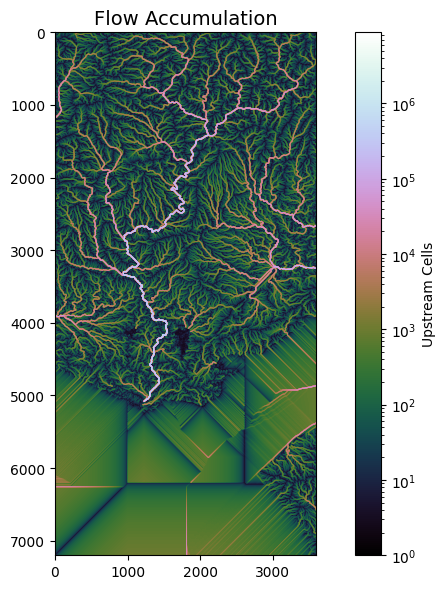

In [34]:
fig, ax = plt.subplots(figsize=(8,6)) # Create a plot figure
fig.patch.set_alpha(0) # Set transparency to 0 for the figure
im = ax.imshow(acc, zorder=2, # Add the flow accumulation layer
               cmap='cubehelix', # Use a cubehelix colormap
               norm=colors.LogNorm(1, acc.max()), # Set the norm to a LogNorm object
               interpolation='bilinear') # Use bilinear interpolation for the plot
plt.colorbar(im, ax=ax, label='Upstream Cells') # Add a colorbar and label for the legend
plt.title('Flow Accumulation', size=14)
plt.tight_layout()

# DEM Without Resolving Pits, Depressions, Flats

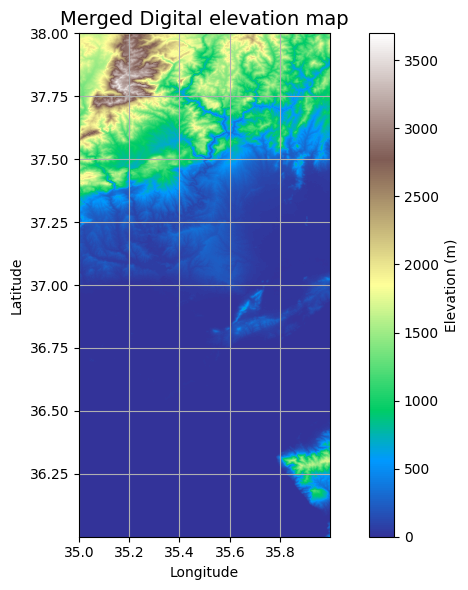

In [35]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show

# Birleştirilmiş tif dosyasının yolu
merged_output_path = 'D:\input\Taskin_Hesap_Staj\merged_output.tif'

# Raster dosyasını açın
merged_dataset = rasterio.open(merged_output_path)

# Raster verisini alın
merged_data = merged_dataset.read(1)

# Haritayı çizdirin
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(merged_data, extent=merged_dataset.bounds, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Merged Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

plt.show()

In [36]:
grid = Grid.from_raster('D:\input\Taskin_Hesap_Staj\merged_output.tif')
dem = grid.read_raster('D:\input\Taskin_Hesap_Staj\merged_output.tif')
# Condition DEM
# ----------------------
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [37]:
# Determining D8 flow directions from DEM
dirmap = (64, 128, 1, 2, 4, 8, 16, 32) # D8
    
# Computing flow directions
fdir = grid.flowdir(inflated_dem, dirmap=dirmap) # D8 flow directions

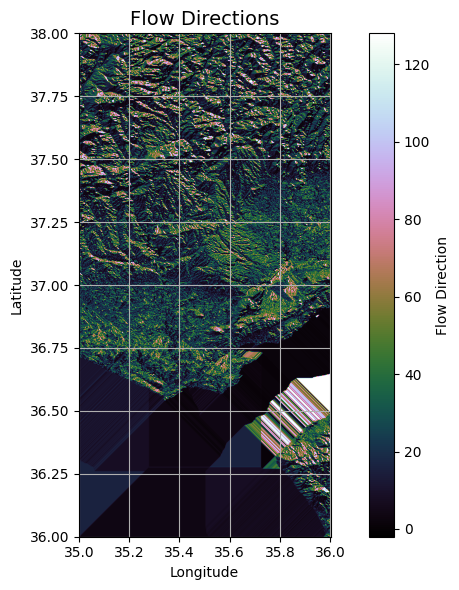

In [38]:
# Converting the 'fdir' map to a default NumPy array named 'fdir_data'
fdir_data = fdir.view(np.ndarray)

fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(fdir_data, extent=grid.extent, cmap='cubehelix', zorder=1)  # preferred color map
plt.colorbar(label='Flow Direction')
plt.grid(zorder=0)
plt.title('Flow Directions', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

plt.show()

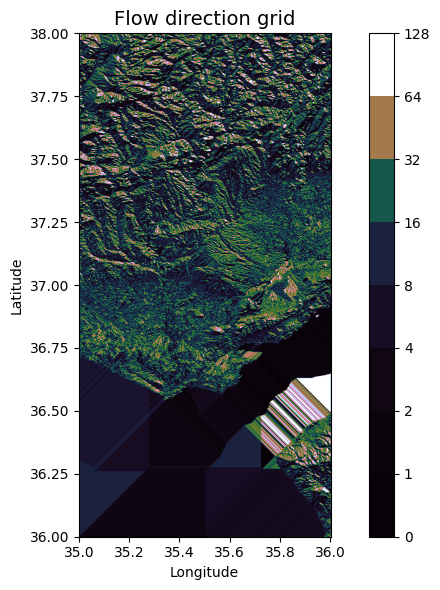

In [39]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='cubehelix', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

In [40]:
# Calculating flow accumulation
acc = grid.accumulation(fdir, dirmap=dirmap)

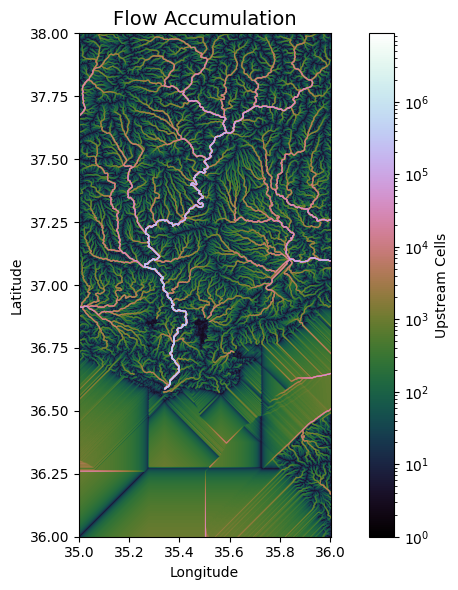

In [41]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(acc, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

In [42]:
# Delineating the catchment
# Specifying our pour point
x, y = 35.47028, 36.979168

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 10, (x, y)) # Snap pour point to DEM

catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

# Clipping the bounding box to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

Pour Point Belirleme:
x, y = 35.47028, 36.979168: Bu satır, suyun tahminen havzanın dışına aktığı bir noktayı belirleyen koordinatları (enlem ve boylam) belirtir. Bu nokta, havzanın belirlenmesine başlamak için kullanılır.

Pour Noktasının Yakalanması:
x_snap, y_snap = grid.snap_to_mask(acc > 10, (x, y)): Bu satır, belirtilen pour noktasını, akış birikiminin 10'dan büyük olduğu bir hücrede bulunan bir konuma "yakalar". Bu, pour noktasının yeterli akışa sahip bir hücrede olmasını sağlamak için yapılır.

Havzanın Belirlenmesi:
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, xytype='coordinate'): Bu satır, yakalanan pour noktasından başlayarak akış yolu izleyerek havza alanını belirler. fdir dizisi akış yönü bilgisini içerir ve dirmap akış yönlerine karşılık gelen yönlendirme haritasıdır.

Havzayı Kesmeye:
grid.clip_to(catch): Bu satır, ızgaranın uzantısını belirlenen havza alanına keser. Bu, sonraki analizlerin veya görselleştirmelerin yalnızca havza alanına odaklanmasını sağlar.

Kesilmiş Havzanın Görüntülenmesi:
clipped_catch = grid.view(catch): Bu satır, kesilmiş havzanın bir görünümünü oluşturur. Bu görünümü, görselleştirme veya analiz için kullanabilirsiniz.

Özetlemek gerekirse, bu kod parçası bir pour noktasını belirler, akış birikimi temel alınarak DEM'de uygun bir konuma "yakalar", akış yönü bilgilerini kullanarak havza alanını belirler, ızgaranın uzantısını havza alanına keser ve kesilmiş havzanın görselleştirme veya analiz için bir görünümünü sağlar.

Text(0.5, 1.0, 'Delineated Catchment')

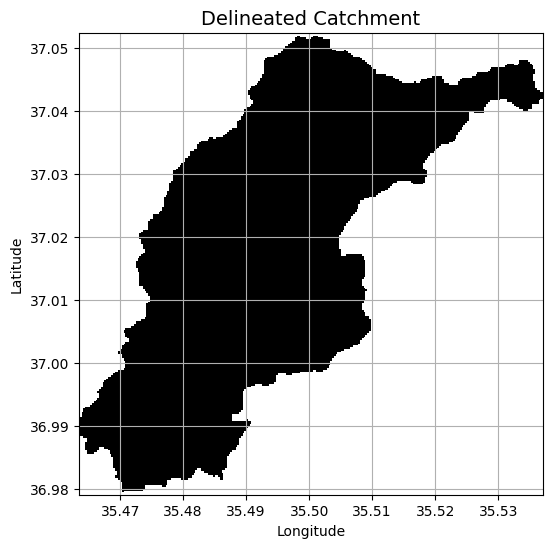

In [43]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(np.where(clipped_catch, clipped_catch, np.nan), extent=grid.extent,
               zorder=1, cmap='Greys_r') # Plot the catchment
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment', size=14)

In [44]:
# Extracting river network
branches = grid.extract_river_network(fdir, acc > 50, dirmap=dirmap) # Extract branches

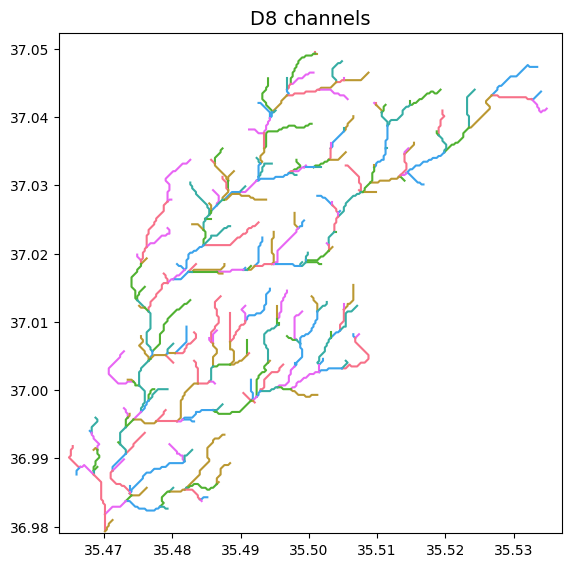

In [45]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

D8 Kanallarını Çizdirmek:

for branch in branches['features']:: Bu satır, 'branches' sözlüğündeki özelliklerin üzerinde bir döngü başlatır.

line = np.asarray(branch['geometry']['coordinates']): Bu satır, mevcut şube öğesinin koordinatlarını alır ve bunları NumPy dizisine dönüştürür.

plt.plot(line[:, 0], line[:, 1]): Bu satır, şubenin x ve y koordinatlarını çizer ve D8 kanalını temsil eden bir çizgi grafiği oluşturur.

In [46]:
# Calculate distance to outlet from each cell
dist = grid.distance_to_outlet(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap,
                               xytype='coordinate')

Bu kod, her hücrenin çıkış noktasına olan uzaklığını hesaplar. Çıkış noktası, belirtilen pour point (dökme noktası) konumuna olan uzaklığını her hücre için ölçer. x_snap ve y_snap belirtilen dökme noktasının koordinatlarını temsil eder. fdir akış yönü haritasını ve dirmap akış yönleri eşlemesini içerir. xytype parametresi koordinat türünü belirtir (burada 'coordinate' olarak belirtilmiş).

Sonuç olarak, her hücrenin belirtilen dökme noktasına olan uzaklığı bu işlemle hesaplanmış olur.

Text(0.5, 1.0, 'Flow Distance')

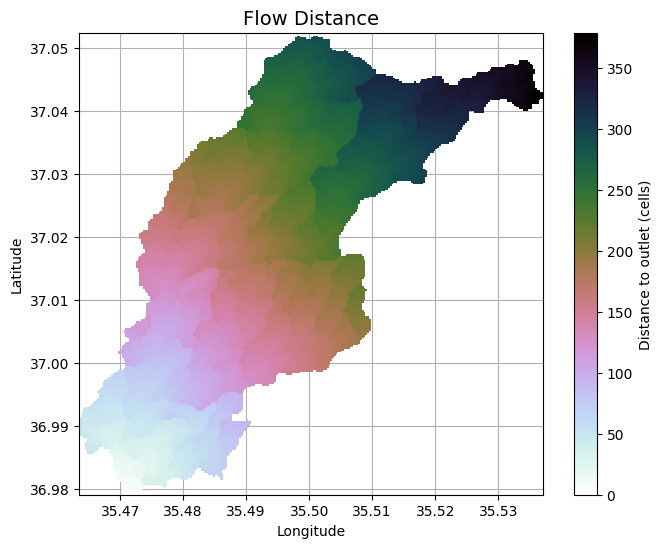

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distance to outlet (cells)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flow Distance', size=14)

Bu kod, her hücrenin 'pour point'e olan uzaklığını görselleştirir. dist dizisi, her hücrenin belirtilen 'pour point'e olan hücre sayısı cinsinden uzaklığını içerir. Kod, bu uzaklık değerlerini renk haritası ile görselleştirir ve harita üzerindeki her hücreye bu uzaklık değerini atar.

fig, ax = plt.subplots(figsize=(8,6)): Boş bir görsel figür ve eksen (plot) oluşturulur.

fig.patch.set_alpha(0): Figürün arka planının şeffaflığını ayarlar.

plt.grid('on', zorder=0): Izgara çizgilerini görselde görüntüler.

im = ax.imshow(dist, extent=grid.extent, zorder=2, cmap='cubehelix_r'): dist dizisini, grid.extent sınırlarında görselde gösterir. Renk haritası olarak 'cubehelix_r' kullanılır. zorder değeri, katman düzenini belirtir.

plt.colorbar(im, ax=ax, label='Distance to outlet (cells)'): Renk haritasına ait renk skalası (colorbar) eklenir.

plt.xlabel('Longitude') ve plt.ylabel('Latitude'): Eksen etiketleri belirlenir.

plt.title('Flow Distance', size=14): Görselin başlığı belirlenir.

plt.tight_layout(): Görselin düzenini düzeltir.

plt.show(): Görseli görüntüler.

In [2]:
grid = Grid.from_raster('D:\input\Taskin_Hesap_Staj\merged_output.tif')
dem = grid.read_raster('D:\input\Taskin_Hesap_Staj\merged_output.tif')

# Visualizing Digital Elevation Models in 3D

In [3]:
import numpy as np
import rasterio
from mayavi import mlab

In [4]:
import os
os.environ['ETS_TOOLKIT'] = 'qt5'

In [5]:
print(dem)

[[1745 1747 1747 ... 1312 1316 1320]
 [1747 1749 1749 ... 1317 1320 1322]
 [1749 1750 1751 ... 1325 1327 1328]
 ...
 [   0    0    0 ...  587  583  579]
 [   0    0    0 ...  590  587  583]
 [   0    0    0 ...  592  590  588]]


In [6]:
print(dem.shape)

(7201, 3601)


In [7]:
#mlab.figure('Visualizing DEM in 3D') # Create a new figure
#nrows, ncols = dem.shape
#x, y = np.meshgrid(np.arange(ncols), np.arange(nrows))
#z = dem
#mesh = mlab.mesh(x, y, z, colormap='terrain')
#mlab.show()

# References

Pysheds Basics:
*    Title: http://mattbartos.com/pysheds/
*    Author: Matt Bartos
*    Date: May 16 2023
*    Code version: __version__ = "0.3.5"
*    Availability: https://github.com/mdbartos/

Visualizing DEM in 3D Basics:
*    Title: https://www.linkedin.com/company/mining-geologist/
*    Author: Mining Geologist
*    Date: Dec 27 2022
*    Code version: -
*    Availability: https://www.youtube.com/watch?v=RTA4X1eCyos
